In [1]:
import pathlib
from typing import List, Dict

import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# Configuration
BASE_DIR = pathlib.Path("..")
DATA_DIR = BASE_DIR / "../data/annotation/sharing"
OUTPUT_DIR = BASE_DIR / "figures/paper figures/EDFigure11"
SCRIPT_DIR = BASE_DIR / "scripts"
METHOD = "wilcoxon"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
H5AD_FILE = DATA_DIR / "all_sharing.h5ad.gz"
USE_FILTERED_GENES = True
TISSUE_COMBOS_TO_PROCESS = ['LN_SP']  # Add the specific combinations you want, or set to None for all
TISSUE_COMBO_TO_COLUMN = {
    'LN_LN': 'shared_LN_LN',
    'LN_SP': 'shared_LN_SP',
    'LN_PB': 'shared_LN_PB',
    "BM_PB": 'shared_BM_PB',
    "SP_PB": 'shared_SP_PB',
    "SP_BM": 'shared_SP_BM',
    'LN_BM': 'shared_LN_BM',   
}

# Figure settings
SAVEFIG_ARGS = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.1,
    "transparent": True,
}
OUTPUT_FORMATS = [".png", ".pdf"]
OUTPUT_SUFFIX = ""

def setup_plotting():
    """Set up plotting parameters for consistent figure output."""
    mpl.rc("savefig", dpi=300)
    sc.set_figure_params(scanpy=False,
        dpi_save=150,
        frameon=False,
        vector_friendly=True,
        fontsize=6,
        figsize=(3,3),
        format='pdf',
        transparent=True
    )
    sns.set_style("ticks")
    plt.style.use(SCRIPT_DIR / 'bursa.mplstyle')

def plot_custom_dotplot(adata: sc.AnnData, markers: List[str], groupby: str = 'shared'):
    """Create a custom dot plot for gene expression analysis."""
    print(f"Unique values in '{groupby}' column: {adata.obs[groupby].unique()}")
    
    # Remove NaN values
    adata = adata[~adata.obs[groupby].isna()].copy()
    
    # Ensure the groupby column is categorical
    adata.obs[groupby] = adata.obs[groupby].astype('category')
    
    if len(adata.obs[groupby].cat.categories) < 2:
        print(f"Warning: Only one category present in {groupby}. Cannot create dotplot.")
        return None

    print(f"Number of cells in each category:")
    print(adata.obs[groupby].value_counts(dropna=False))
    print(f"Markers to be plotted: {markers}")
    print(f"Markers present in data: {[m for m in markers if m in adata.var_names]}")

    fig, ax = plt.subplots(figsize=(3, 2.25))
    try:
        dp = sc.pl.DotPlot(adata, markers, groupby=groupby, ax=ax, 
                           vmax=2, vmin=0, expression_cutoff=0)
        dp.legend(width=0.6)
        dp.swap_axes()
        dp.add_totals(color='0.4', size=0.5).style(dot_edge_color='black', 
                                                   largest_dot=55, 
                                                   dot_edge_lw=0.2, 
                                                   cmap='Purples').show()

        # Adjust legend and labels
        axes = dp.get_axes()
        axes['size_legend_ax'].set_title("% cells\nexpression > 0", fontsize=6)
        axes['color_legend_ax'].set_title("Mean Expression\n($log_2$ UMI per 10K)", fontsize=6)

        for ax in [axes['size_legend_ax'], axes['color_legend_ax']]:
            ax.tick_params(axis='x', labelsize=5)

        plt.tight_layout()
        return fig
    except Exception as e:
        print(f"Error creating dotplot: {str(e)}")
        return None


def process_adata(adata: sc.AnnData, tissue_combo: str, descriptor: str, method: str = 'wilcoxon'):
    """Process AnnData object for a specific tissue combination and descriptor."""
    adata.obs.loc[:,'shared'] = adata.obs[TISSUE_COMBO_TO_COLUMN[tissue_combo]]
    print(f"Initial: {adata.shape[0]} cells")
    
    # Remove NaN values
    adata = adata[~adata.obs['shared'].isna()].copy()
    print(f"After removing NaNs: {adata.shape[0]} cells")
    
    # Convert boolean categories to strings and set as categorical
    adata.obs['shared'] = adata.obs['shared'].map({True: 'True', False: 'False'})
    adata.obs['shared'] = adata.obs['shared'].astype('category')
    
    # Remove unused categories
    adata.obs['shared'] = adata.obs['shared'].cat.remove_unused_categories()
    
    print(f"\n{tissue_combo}\n{descriptor}\n")
    print(f"Value counts for 'shared' column:\n{adata.obs['shared'].value_counts()}")
    
    # Check if both categories are present
    if len(adata.obs['shared'].cat.categories) < 2:
        print(f"Warning: Only one category present in 'shared' column for {tissue_combo}, {descriptor}. Skipping analysis.")
        return None

    # Perform rank_genes_groups analysis
    sc.tl.rank_genes_groups(adata, groupby='shared', method=method, pts=True)
    sc.pl.rank_genes_groups(adata, key='rank_genes_groups')
    sc.tl.filter_rank_genes_groups(adata, min_fold_change=0.8, min_in_group_fraction=0.2, max_out_group_fraction=0.6)

    return adata

def save_results(adata: sc.AnnData, tissue_combo: str, descriptor: str):
    """Save differential expression results."""
    folder_path = DATA_DIR.parent / tissue_combo / descriptor
    folder_path.mkdir(parents=True, exist_ok=True)
    print(f"Created {folder_path}")

    sc.get.rank_genes_groups_df(adata, group="True", key='rank_genes_groups').to_csv(folder_path / "de_genes.tab", sep='\t')
    sc.get.rank_genes_groups_df(adata, group="True", key='rank_genes_groups_filtered').to_csv(folder_path / "filtered_de_genes_true.tab", sep='\t')
    sc.get.rank_genes_groups_df(adata, group="False", key='rank_genes_groups_filtered').to_csv(folder_path / "filtered_de_genes_false.tab", sep='\t')



In [2]:
setup_plotting()

print("Loading data...")
adata = sc.read_h5ad(H5AD_FILE)

mb_adata = adata[adata.obs.celltypist.str.contains('Memory B|Age|Prolif')]
asc_adata = adata[adata.obs.celltypist.str.contains("Plasma")]
mb_adata_LN = mb_adata[mb_adata.obs.tissue == 'LN']

adata_dict = {'mb_cells': mb_adata, 'as_cells': asc_adata, 'LN_only': mb_adata_LN}

# Determine which tissue combinations to process
tissue_combos_to_process = TISSUE_COMBOS_TO_PROCESS if TISSUE_COMBOS_TO_PROCESS is not None else TISSUE_COMBO_TO_COLUMN.keys()


Loading data...


/home/michaelswift/miniconda3/envs/bursa2ndary/lib/python3.12/site-packages/pandas/core/indexing.py:1857: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


Initial: 89201 cells
After removing NaNs: 75618 cells

LN_SP
mb_cells

Value counts for 'shared' column:
shared
False    73499
True      2119
Name: count, dtype: int64


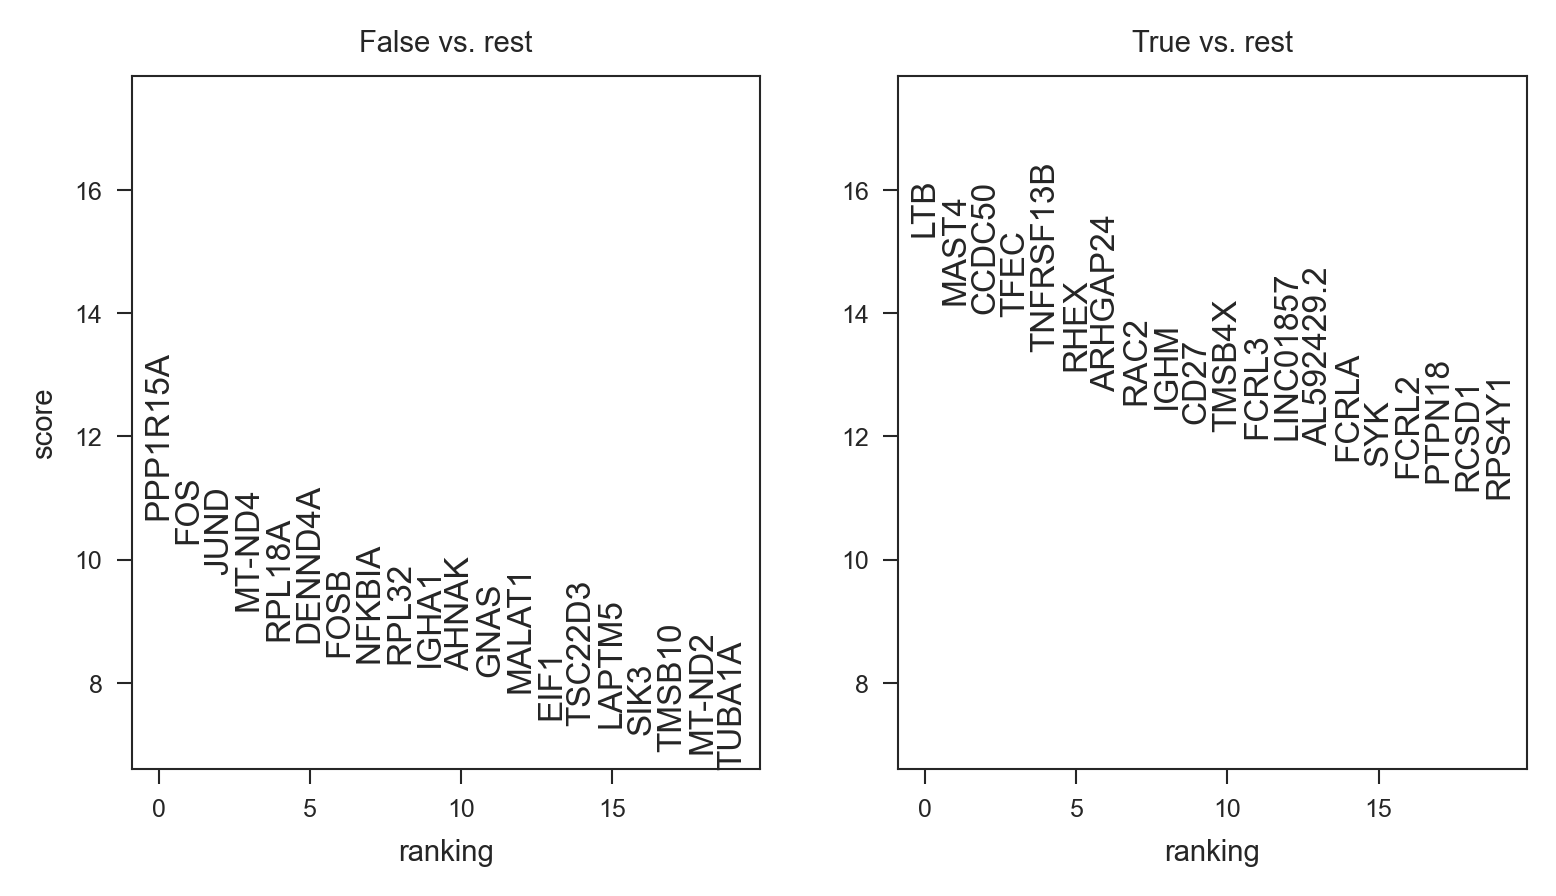

True markers: ['MAST4', 'TFEC', 'RHEX', 'FCRL3', 'AL592429.2', 'LILRA4', 'CD1C', 'LINC00996']
False markers: ['LARGE1']
Unique values in 'shared' column: ['False', 'True']
Categories (2, object): ['False', 'True']
Number of cells in each category:
shared
False    73499
True      2119
Name: count, dtype: int64
Markers to be plotted: ['MAST4', 'TFEC', 'RHEX', 'FCRL3', 'AL592429.2', 'LILRA4', 'CD1C', 'LINC00996', 'LARGE1']
Markers present in data: ['MAST4', 'TFEC', 'RHEX', 'FCRL3', 'AL592429.2', 'LILRA4', 'CD1C', 'LINC00996', 'LARGE1']


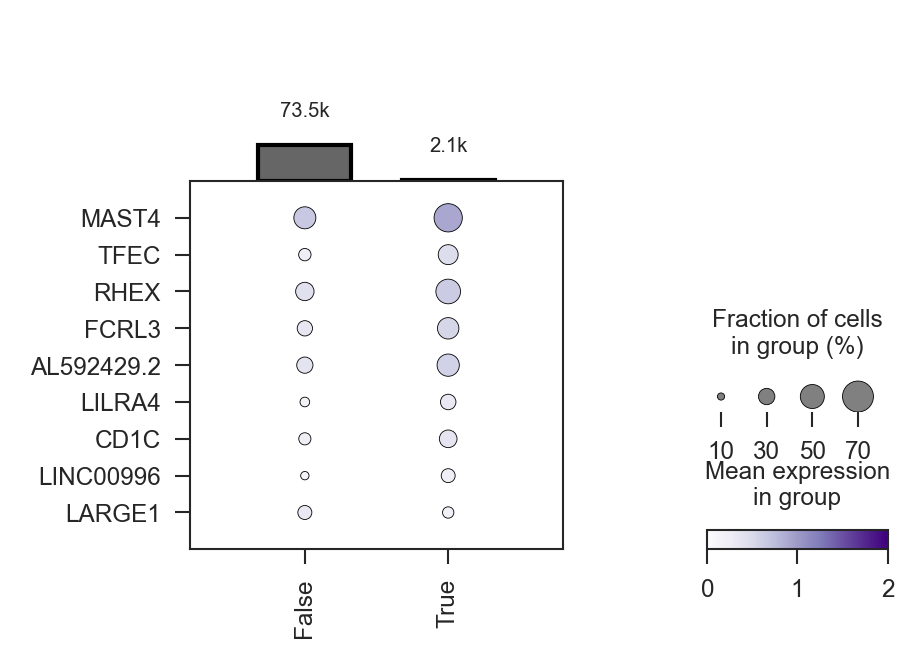

Saved dotplot for LN_SP, mb_cells
Created ../../data/annotation/LN_SP/mb_cells


/home/michaelswift/miniconda3/envs/bursa2ndary/lib/python3.12/site-packages/pandas/core/indexing.py:1857: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


Initial: 26366 cells
After removing NaNs: 17566 cells

LN_SP
as_cells

Value counts for 'shared' column:
shared
False    15790
True      1776
Name: count, dtype: int64


<Figure size 450x450 with 0 Axes>

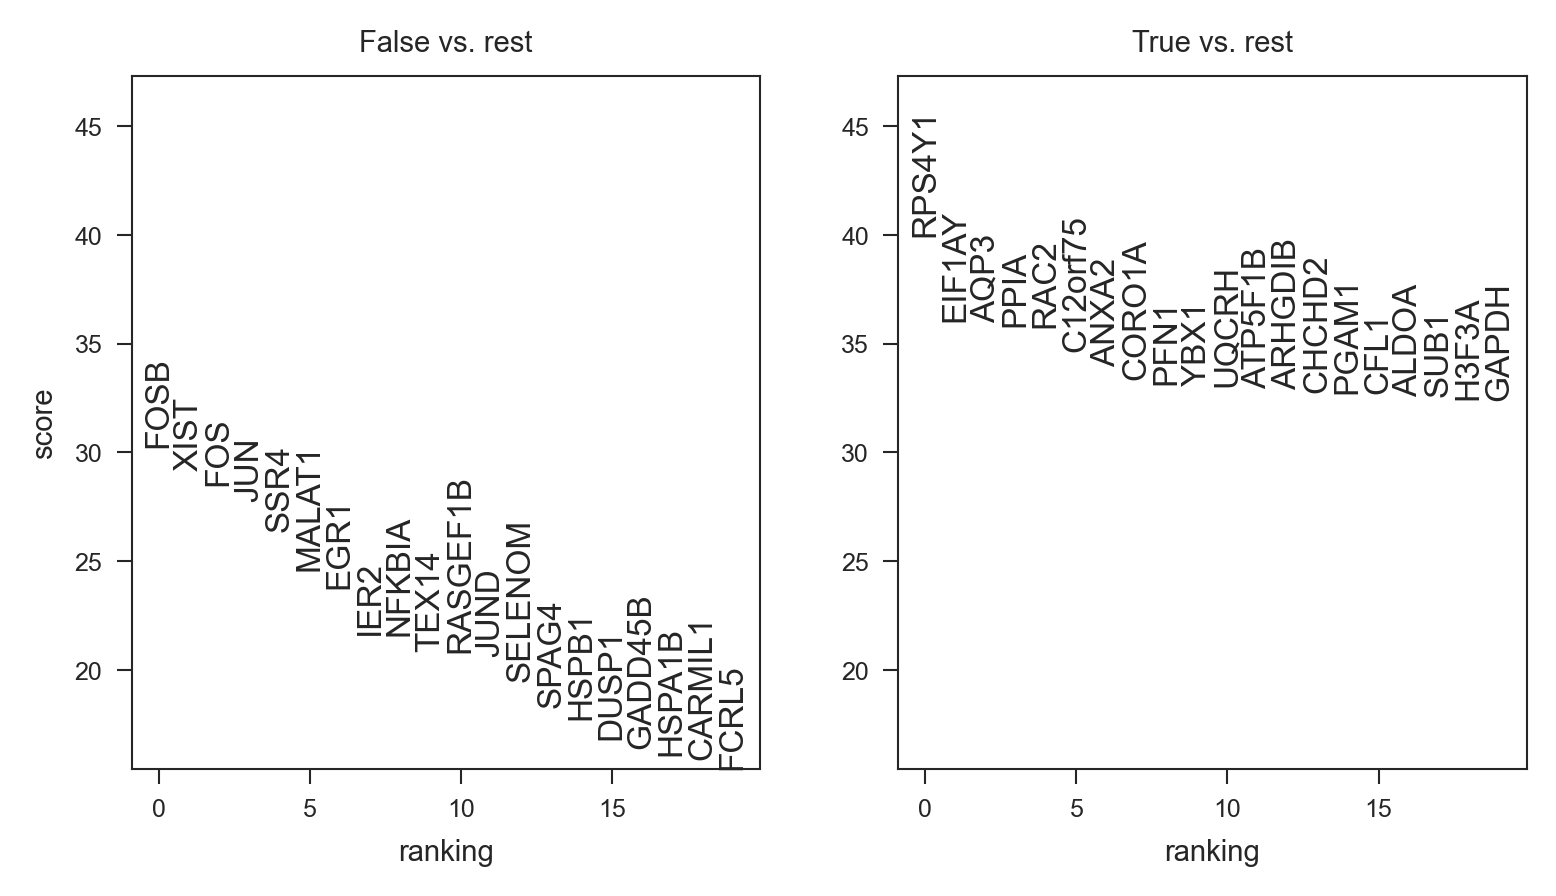

True markers: ['RPS4Y1', 'EIF1AY', 'AQP3', 'C12orf75', 'ANXA2', 'CORO1A', 'ATP5F1B', 'ARHGDIB']
False markers: ['FOSB', 'XIST', 'EGR1', 'RASGEF1B', 'SELENOM', 'SPAG4', 'HSPB1', 'HSPA1B']
Unique values in 'shared' column: ['False', 'True']
Categories (2, object): ['False', 'True']
Number of cells in each category:
shared
False    15790
True      1776
Name: count, dtype: int64
Markers to be plotted: ['RPS4Y1', 'EIF1AY', 'AQP3', 'C12orf75', 'ANXA2', 'CORO1A', 'ATP5F1B', 'ARHGDIB', 'FOSB', 'XIST', 'EGR1', 'RASGEF1B', 'SELENOM', 'SPAG4', 'HSPB1', 'HSPA1B']
Markers present in data: ['RPS4Y1', 'EIF1AY', 'AQP3', 'C12orf75', 'ANXA2', 'CORO1A', 'ATP5F1B', 'ARHGDIB', 'FOSB', 'XIST', 'EGR1', 'RASGEF1B', 'SELENOM', 'SPAG4', 'HSPB1', 'HSPA1B']


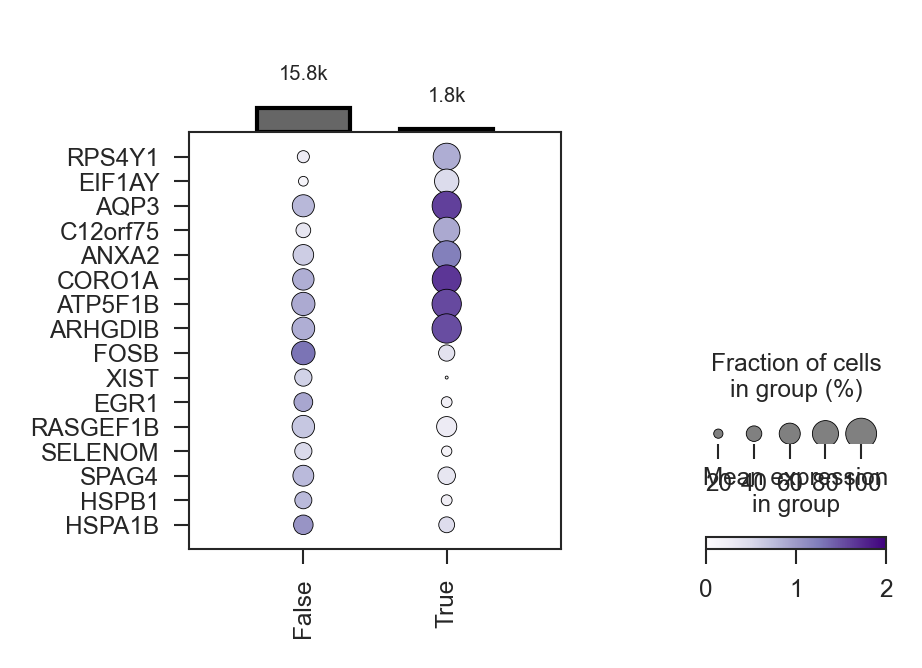

Saved dotplot for LN_SP, as_cells
Created ../../data/annotation/LN_SP/as_cells


/home/michaelswift/miniconda3/envs/bursa2ndary/lib/python3.12/site-packages/pandas/core/indexing.py:1857: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


Initial: 43590 cells
After removing NaNs: 43590 cells

LN_SP
LN_only

Value counts for 'shared' column:
shared
False    42418
True      1172
Name: count, dtype: int64


In [3]:
for tissue_combo in tissue_combos_to_process:
    if tissue_combo not in TISSUE_COMBO_TO_COLUMN:
        print(f"Warning: {tissue_combo} is not a valid tissue combination. Skipping.")
        continue

    for descriptor, ad in adata_dict.items():
        ad = process_adata(ad, tissue_combo, descriptor, method=METHOD)
        
        # Get differential expression results
        dedf_True = sc.get.rank_genes_groups_df(ad, group="True", key='rank_genes_groups')
        dedf_False = sc.get.rank_genes_groups_df(ad, group="False", key='rank_genes_groups')
        dedf_filtered_true = sc.get.rank_genes_groups_df(ad, group="True", key='rank_genes_groups_filtered')
        dedf_filtered_false = sc.get.rank_genes_groups_df(ad, group="False", key='rank_genes_groups_filtered')
        # Select markers for dotplot
        if USE_FILTERED_GENES:
            true_markers = dedf_filtered_true.dropna(subset='names')['names'][:8].tolist()
            false_markers = dedf_filtered_false.dropna(subset='names')['names'][:10 ].tolist()
        else:
            true_markers = dedf_True['names'][:8].tolist()
            false_markers = dedf_False['names'][:10].tolist()
        markers = true_markers + false_markers
        
        print(f"True markers: {true_markers}")
        print(f"False markers: {false_markers}")

        try:
            fig = plot_custom_dotplot(ad, markers)
            if fig is not None:
                figure_folder = OUTPUT_DIR / tissue_combo / descriptor
                figure_folder.mkdir(parents=True, exist_ok=True)
                for fmt in OUTPUT_FORMATS:
                    fig.savefig(figure_folder / f"dotplot{OUTPUT_SUFFIX}{fmt}", **SAVEFIG_ARGS)
                print(f"Saved dotplot for {tissue_combo}, {descriptor}")
                plt.close(fig)
            else:
                print(f"Skipped dotplot for {tissue_combo}, {descriptor} due to insufficient data")
        except Exception as e:
            print(f"Dot plot failed for {tissue_combo}, {descriptor}. Error: {str(e)}")
            print("Dot plot tried with", len(markers), "markers, could be an issue")

        save_results(ad, tissue_combo, descriptor)

In [ ]:
sc.tl.rank_genes_groups(ad, groupby='shared', reference='False', method=METHOD, pts=True)

In [ ]:
ad.uns['rank_genes_groups']

{'params': {'groupby': 'shared',
  'reference': 'False',
  'method': 't-test',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'pts':                False      True
 AL627309.1  0.001910  0.002560
 AL627309.5  0.005328  0.006826
 AP006222.2  0.000424  0.000000
 AL669831.2  0.000094  0.000000
 LINC01409   0.072422  0.095563
 ...              ...       ...
 AC233755.1  0.022538  0.012799
 AC136616.3  0.000094  0.000853
 AC136616.2  0.000495  0.000000
 AC141272.1  0.001886  0.002560
 AC007325.4  0.000236  0.000000
 
 [27218 rows x 2 columns],
 'names': rec.array([('IGHM',), ('ARHGAP24',), ('CCDC50',), ..., ('AL513165.1',),
            ('CCDC151',), ('HLA-DQA2',)],
           dtype=[('True', 'O')]),
 'scores': rec.array([( 11.279011,), ( 11.263022,), ( 11.240496,), ...,
            (-14.292596,), (-15.87827 ,), (-18.320679,)],
           dtype=[('True', '<f4')]),
 'pvals': rec.array([(3.72234148e-28,), (4.31719778e-28,), (5.64653559e-28,), ...,
            (3.1